<a href="https://colab.research.google.com/github/hahajjjun/monai_bootcamp_2022/blob/main/MARS_MONAI_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 💻 MARS MONAI Segmentation Tutorial
### ❗ Disclaimer ❗ MONAI 2022 Bootcamp의 자료를 발췌, 수정하였습니다.
### ✌ 데이터셋 설명
- 심장의 Left Ventricle Segmentation
- [Sunnybrook Cardiac Dataset](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/), 심장 MRI에 대한 이미지입니다.

In [1]:
!nvidia-smi

Wed May  4 13:01:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install monai

     |████████████████████████████████| 721 kB 11.5 MB/s 


### 😀라이브러리 Import

In [3]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import torch

from urllib.request import urlopen
from io import BytesIO

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import monai
from monai.transforms import Compose, AddChannel, ScaleIntensity, ToTensor
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import ArrayDataset
from torch.utils.data import DataLoader
from monai.utils import first, progress_bar
from monai.networks import one_hot
from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

# 재현성
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

### 🍔 Temp 디렉토리를 만들어 주겠습니다.

In [4]:
import os 
import glob
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

temp


### 😢 코랩 용량이 제한되어 있어서, 2MB짜리 작은 데이터셋을 불러오겠습니다.
전처리된 Sunnybrook Cardiac MRI 데이터셋 (2MB) :  [VPH Summer SChool 2019](https://www.vph-institute.org/events/2019-vph-summer-school.html)

In [5]:
device = torch.device("cuda:0")
DATA_NPZ = "https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs.npz"

In [6]:
%%time
remote_file = urlopen(DATA_NPZ)
npz = BytesIO(remote_file.read())

CPU times: user 21.9 ms, sys: 9.73 ms, total: 31.6 ms
Wall time: 1.07 s


### 👀 데이터는 이미지와 segmentation map으로 나누어져서 딕셔너리 형태로 저장되어 있습니다!

In [7]:
data = np.load(npz)  # load all the data from the archive

images = data["images"]  # images in BHW array order
segs = data["segs"]  # segmentations in BHW array order
case_indices = data["caseIndices"]  # the indices in `images` for each case

이미지를 0~1 사이로 정규화하는 것은 아주 중요합니다.

(420, 64, 64) (420, 64, 64)


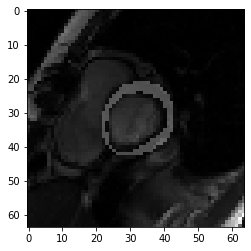

In [8]:
images = images.astype(np.float32) / images.max()  # normalize images
print(images.shape, segs.shape)
plt.imshow(images[13] + segs[13] * 0.25, cmap="gray")  # show image 13 with segmentation

### 🏭 이미지 전처리와 증강(Augmentation)
- `NPZDictItemDataset`은 MONAI에서 지원하는 데이터셋 클래스의 일종입니다.
- 이미지와 Segmentation map을 짝지어서(Paired) 가져올 수 있는 클래스입니다.
- MONAI 내부적으로 여러 가지 Transformation을 지원하고 있습니다.
- Random Flip, Rotation, Zoom, Elastic Deformation 등이 있습니다.

In [10]:
# new imports
from monai.data import  NPZDictItemDataset

############
batch_size = 50
num_workers = 2
aug_prob = 0.5
############
from monai.transforms import (
    Activationsd, 
    AsDiscreted,
    AddChanneld,
    ScaleIntensityd,
    CastToTyped,
    EnsureTyped,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    Rand2DElasticd,
    RandAffined,
)

- Segmentation Map은 0과 1, 이진 분류로 이루어져 있습니다.
- 크기를 조절하는 과정에서 Interpolation(보간법)을 사용할 경우 <br/> 0과 1이 아닌 0.5, 0.75와 같은 값으로 들어갈 수 있기 때문에 0과 1 값만을 사용하도록 설정하는 과정입니다.

In [11]:
####
# use these when interpolating binary segmentations to ensure values are 0 or 1 only
zoom_mode = monai.utils.enums.InterpolateMode.NEAREST
elast_mode = monai.utils.enums.GridSampleMode.BILINEAR, monai.utils.enums.GridSampleMode.NEAREST

- MONAI의 특이한 점은 "Key" 개념입니다.
- 데이터셋에 접근할 때`CommonKeys.IMAGE`라는 키로 접근하면 dataset에서 IMAGE가, CommonKeys.LABEL이라는 키로 접근하면 LABEL이 튀어나오게 됩니다.

In [12]:
#########
# for keys 
from monai.utils.enums import CommonKeys
both_keys = (CommonKeys.IMAGE, CommonKeys.LABEL)
image_only = CommonKeys.IMAGE

- 데이터 증강(Augmentation) : 주어진 데이터셋이 2MB로 매우 작기 때문에 충분한 데이터 증강이 필요합니다.
- 여러 가지 Transformation들을 나열한 다음, `Compose()`로 묶어 주면 됩니다.

In [13]:
train_trans = Compose(
    [
        ScaleIntensityd(image_only),
        AddChanneld(both_keys),
        RandRotate90d(keys=both_keys, prob=aug_prob),
        RandFlipd(keys=both_keys, prob=aug_prob),
        RandZoomd(keys=both_keys, prob=aug_prob, mode=zoom_mode),
        Rand2DElasticd(keys=both_keys, prob=aug_prob, spacing=10, magnitude_range=(-2, 2), mode=elast_mode),
#         RandAffined(keys=both_keys, prob=aug_prob, rotate_range=1, translate_range=16, mode=elast_mode),
        CastToTyped(both_keys, (np.float32, np.int32)),
        EnsureTyped(both_keys),
    ]
)

val_trans = Compose(
    [
        ScaleIntensityd(image_only),
        AddChanneld(both_keys),
        CastToTyped(both_keys, (np.float32, np.int32)),
        EnsureTyped(both_keys),
    ]
)

### 👼 데이터셋과 데이터로더 구성하기
- 여기서 npz는 numpy zip file의 약자로, 주어진 데이터셋이 npz file 형태입니다.
- monai.data.<b>NPZDictItemDataset</b>(`npzfile, keys, transform=None, other_keys=()`)

**파라미터**
- <b>npzfile</b> (`Union[str, IO]`) – Path to .npz file or stream containing .npz file data
- <b>keys</b> (`Dict[str, str]`) – Maps keys to load from file to name to store in dataset
- <b>transform</b> (`Optional[Callable[…, Dict[str, Any]]]`) – Transform to apply to batch dict
- <b>other_keys</b> (`Optional[Sequence[str]]`) – secondary data to load from file and store in dict other_keys, not returned by __getitem__
- <b>data</b> – input data to load and transform to generate dataset for model.
- <b>transform</b> – a callable data transform on input data.

In [14]:
# for keys 
from monai.utils.enums import CommonKeys

# create training and validation datasets from the whole set of images, these will be resized below based on case indices
keys_train = {"images": CommonKeys.IMAGE, "segs": CommonKeys.LABEL} 
keys_val =  {"images": CommonKeys.IMAGE, "segs": CommonKeys.LABEL} 

train_dat = NPZDictItemDataset( npz, keys_train , train_trans  , ("caseIndices",) ) 
val_dat = NPZDictItemDataset( npz, keys_val , val_trans  ) 

- 마지막 6개 case를 validation 용으로 사용하겠습니다.
- 데이터로더는 Pytorch의 DataLoader 클래스를 상속받고 있어서, 동일한 방법으로 사용이 가능합니다.

In [15]:
# extract the case indices array
case_indices = train_dat.other_keys["caseIndices"] # TODO data["caseIndices"]   to train_dat
val_index = case_indices[-6, 0]  # keep the last 6 cases for testing

train_dat = train_dat[:val_index]
val_dat = val_dat[val_index:]

train_loader = DataLoader(
    dataset=train_dat,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

val_loader = DataLoader(
    dataset=val_dat,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

### 🏍 Model 구축하기
**아래는 MONAI가 지원하는 모델과 여러 가지 기본 Block들입니다.**
- [Layers](https://docs.monai.io/en/stable/networks.html#layers) : Act, Conv, Norm, Dropout, Flatten, Reshape, Pad, Pool, SkipConnection
- [Blocks](https://docs.monai.io/en/stable/networks.html#module-monai.networks.blocks) : ADN, Convolution, Synamic UnetBlock, FCN, GCN, Squeeze-andExcitation, ResNeXt, SABlock, Transformer Block, 
- [Nets](https://docs.monai.io/en/stable/networks.html#nets)  : DenseNet121, EfficientNet, SegResNet, ResNet, SENet154, DyUNet, ❗ UNet ❗, AutoEncoder, VarAutoEncoder, ViT, 
- U-Net의 구조 <br/>
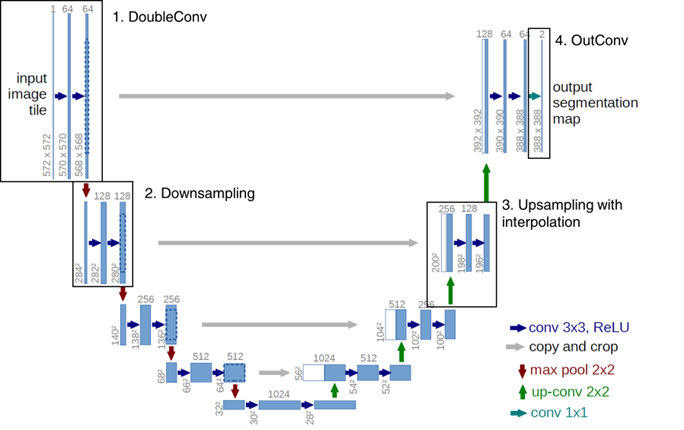

In [16]:
from monai.networks.nets import UNet

device = torch.device("cuda:0")
#net = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=[16, 32, 64], strides=[2, 2], num_res_units=2, dropout=0.2) # 3 layers 
#net = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=[4, 8, 16], strides=[2, 2], num_res_units=2, dropout=0.2) # 3 layers 
net = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=[4, 8, 16, 32,64], strides=[2,2, 2,2], num_res_units=3, dropout=0.4) # 5 layers
#net = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=[16, 32, 64, 128, 256], strides=[2, 2, 2, 2], num_res_units=4, dropout=0.2) # 5 layers
#net = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=[4, 8, 16, 32,64, 128,256], strides=[2, 2, 2, 2,2,2], num_res_units=6, dropout=0.2) # 7 layers

net = net.to(device)

### 🌼손실함수 정의 : 
- Dice Loss를 사용하겠습니다.
- Focal Loss는 불균형한 데이터셋에서 효과적인 손실함수이므로 바꿔보셔도 됩니다!

In [17]:
from monai.losses import DiceLoss
#from monai.losses import FocalLoss
from monai.metrics import DiceMetric
loss = DiceLoss(sigmoid=True)
metric = DiceMetric(include_background=True, reduction="mean")

### ⚒ Optimizer 설정
- Learning Rate를 바꾸어 보시면 됩니다.
- 보통은 하이퍼파라미터를 찾는 프레임워크(Optuna, Ray)를 활용하거나 주어진 후보를 완전탐색하는 Grid Search를 이용합니다.
- 우선 지금은 수동으로 조절해 보시면 됩니다.
- Optimizer도 SGD, RMSprop, Adam, AdamW 등 다양하지만 Adam을 우선 사용했습니다.

In [18]:
lr = 3e-3
opt = torch.optim.Adam(net.parameters(), lr)

In [19]:
num_epochs = 200

### 🚆 Train 루프를 만들자
- MOANI는 **Ignite** 기반의 API를 지원해서, 손쉽게 반복적으로 Train하는 파이프라인을 만들 수 있습니다.
- Ignite는 따로 install해주어야 합니다.

In [25]:
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.8.1"

     |████████████████████████████████| 251 kB 12.8 MB/s 


In [20]:
step_losses = []
epoch_metrics = []
metric_values = []
iter_losses=[]
batch_sizes=[]
epoch_loss_values =[]
total_step = 0
max_epochs = 200
step = 1

- 최종 Segmentation 예측은 0과 1 사이여야 하니 후처리(Postprocessing) 변환을 정의해 주었습니다.

In [21]:
from monai.transforms import Compose, Activationsd, AsDiscreted

post_transform = Compose(
    [Activationsd(keys="pred", sigmoid=True), AsDiscreted(keys=["pred", "label"], threshold_values=True,),]
)

- MONAI는 **핸들러**를 이용해 Train하는 함수를 불러올 수 있는데, 지도 학습 문제를 학습할 때에는 `SupervisedEvaluator`를 사용합니다.

In [26]:
from monai.handlers import StatsHandler, MeanDice, from_engine
from monai.engines import SupervisedEvaluator


evaluator = SupervisedEvaluator(
    device= device, #TODO
    val_data_loader= val_loader, #TODO
    network=net , #TODO
    postprocessing= post_transform, #TODO
    key_val_metric={"val_mean_dice": MeanDice(include_background=True, output_transform=from_engine(["pred", "label"]))},
    val_handlers=[StatsHandler(output_transform=lambda x: None)],
)


- Validation 과정에서는 `Validation Handler`를 사용하면 됩니다.

In [27]:
from monai.handlers import MetricLogger, ValidationHandler
from monai.engines import SupervisedTrainer

logger = MetricLogger(evaluator=evaluator)

trainer = SupervisedTrainer(
    device= device, #TODO
    max_epochs= max_epochs,  #TODO
    train_data_loader= train_loader,  #TODO
    network= net,  #TODO
    optimizer= opt,  #TODO
    loss_function= loss,  #TODO
    train_handlers=[logger, ValidationHandler(1, evaluator)],
)

steps_per_epoch = len(train_dat) // train_loader.batch_size
if len(train_dat) % train_loader.batch_size != 0:
    steps_per_epoch += 1
print(len(train_dat) , train_loader.batch_size, steps_per_epoch)

368 50 8


- Decoration annotator (@)를 사용해서, trainer를 활성화하는 주석을 달아 주어야 합니다.
- Iteration이 끝나거나, EPOCH가 끝나는 등의 이벤트가 발생하면, 핸들러가 이것을 받아 함수를 실행하는 trigger로 활용합니다.

In [28]:
from ignite.engine import Engine, Events

@trainer.on(Events.ITERATION_COMPLETED)
def _end_iter(engine: Engine):
    global step
    loss = np.average([o["loss"] for o in engine.state.output])
    batch_len = len(engine.state.batch[0])
    epoch = engine.state.epoch
    epoch_len = engine.state.max_epochs
    step_total = engine.state.iteration  
    iter_losses.append(loss)
    batch_sizes.append(batch_len)

    print(f"\nepoch {epoch}/{epoch_len}, step {step}/{steps_per_epoch},  total step {step_total}/{steps_per_epoch*epoch_len}, training_loss = {loss:.4f}", end='')
    step += 1
    

@trainer.on(Events.EPOCH_COMPLETED)
def _end_epoch(engine: Engine):
    global step
    overall_average_loss = np.average(iter_losses, weights=batch_sizes)
    epoch_loss_values.append(overall_average_loss)    
    # clear the contents of iter_losses and batch_sizes for the next epoch
    del iter_losses[:]
    del batch_sizes[:]
    
    dice = evaluator.state.metrics["val_mean_dice"]   
    metric_values.append(dice)
    #progress_bar(engine.state.epoch, num_epochs, f"Validation Metric: {dice:7.3}")
    print(f" | avg loss: {overall_average_loss:.4f} Dice Metric: {dice:7.3}", end='')
    step = 1



### 🏃학습을 시작하겠습니다!

In [29]:
trainer.run()


epoch 1/200, step 1/8,  total step 1/1600, training_loss = 0.9123
epoch 1/200, step 2/8,  total step 2/1600, training_loss = 0.9187
epoch 1/200, step 3/8,  total step 3/1600, training_loss = 0.9240
epoch 1/200, step 4/8,  total step 4/1600, training_loss = 0.9203
epoch 1/200, step 5/8,  total step 5/1600, training_loss = 0.9246
epoch 1/200, step 6/8,  total step 6/1600, training_loss = 0.9064
epoch 1/200, step 7/8,  total step 7/1600, training_loss = 0.9055
epoch 1/200, step 8/8,  total step 8/1600, training_loss = 0.9013 | avg loss: 0.9141 Dice Metric:  0.0793
epoch 2/200, step 1/8,  total step 9/1600, training_loss = 0.9051
epoch 2/200, step 2/8,  total step 10/1600, training_loss = 0.9109
epoch 2/200, step 3/8,  total step 11/1600, training_loss = 0.9158
epoch 2/200, step 4/8,  total step 12/1600, training_loss = 0.9099
epoch 2/200, step 5/8,  total step 13/1600, training_loss = 0.9146
epoch 2/200, step 6/8,  total step 14/1600, training_loss = 0.8934
epoch 2/200, step 7/8,  total 

### 📊 학습 결과 시각화
- 대략 Validation Dice Score가 0.6 근처로 수렴하고 있습니다.
- 이미지 수가 적기 때문에, Dice Score의 한계가 있을 수 있습니다.
- Hyperparmeter들을 바꾸면 0.65까지는 오를 수 있으니, 직접 시도해 보셔도 좋을 것 같습니다.

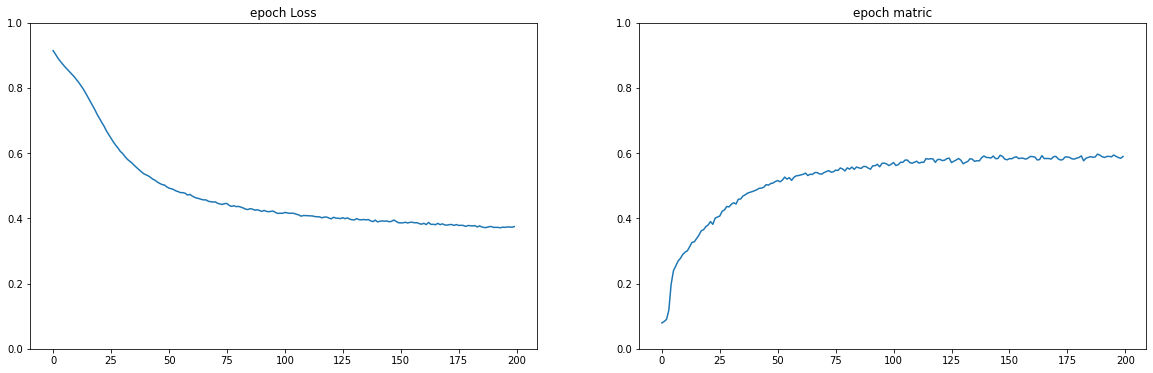

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
 
ax[0].plot(epoch_loss_values)
ax[0].set_title("epoch Loss")
ax[0].set_ylim(0,1)
ax[1].plot(metric_values)
ax[1].set_title("epoch matric")
ax[1].set_ylim(0,1)
plt.show()